# Análise de Classificação - Previsão e Detecção de Risco de Crédito

Este projeto tem como objetivo apenas para fins educacionais, com intuito de praticar todo o conhecimento adquirido no curso de Machine Learning da formação Cientista de Dados, ministrado pela Data Science Academy. Este projeto foi fornecido como exemplo em linguagem R durante o curso, e fiz a conversão para linguagem Python para praticar. Neste exemplo, foi ensinado apenas a regressão logística, porém, nesse jupyter notebook conterá todo o conhecimento adquirido por mim durante o curso.

## Definindo o Problema de Negócio

O objetivo deste projeto é desenvolver um sistema de Previsão e Detecção de Risco de Crédito que possa auxiliar instituições financeiras na avaliação de pedidos de empréstimos baseado nas informações contidas no dataset. Baseado nessas informações, o modelo irá avaliar se aprovará o emprestimo (sim - 1) ou não aprovará o emprestimo (não - 0)

O dataset foi disponibilizado pela Data Sciende Academy.

## Carregando pacotes e Dataset

In [1]:
# Importando pacotes

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score, GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, make_scorer
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline 

In [2]:
# Carregando dataset
df = pd.read_csv('dados/credit_dataset_final.csv')
df.head()

,credit.rating,account.balance,credit.duration.months,previous.credit.payment.status,credit.purpose,credit.amount,savings,employment.duration,installment.rate,marital.status,...,residence.duration,current.assets,age,other.credits,apartment.type,bank.credits,occupation,dependents,telephone,foreign.worker
0,1,1,18,3,2,1049,1,1,4,1,...,4,2,21,2,1,1,3,1,1,1
1,1,1,9,3,4,2799,1,2,2,3,...,2,1,36,2,1,2,3,2,1,1
2,1,2,12,2,4,841,2,3,2,1,...,4,1,23,2,1,1,2,1,1,1
3,1,1,12,3,4,2122,1,2,3,3,...,2,1,39,2,1,2,2,2,1,2
4,1,1,12,3,4,2171,1,2,4,3,...,4,2,38,1,2,2,2,1,1,2


In [3]:
# Coletando X e y
X = df.iloc[:, 1:]
y = df['credit.rating']

# Gerando número de observações e variáveis
observasoes = len(df)
variaveis = df.columns[1:]

## Análise Exploratória

Nesa etapa iremos plotar alguns gráficos para entender melhor os dados, realizar algumas análises e observar como estão distribuidos.

**A variável target está banaceada?**

Não, Será necessário aplicar alguma técnica de balanceamento na variável target.

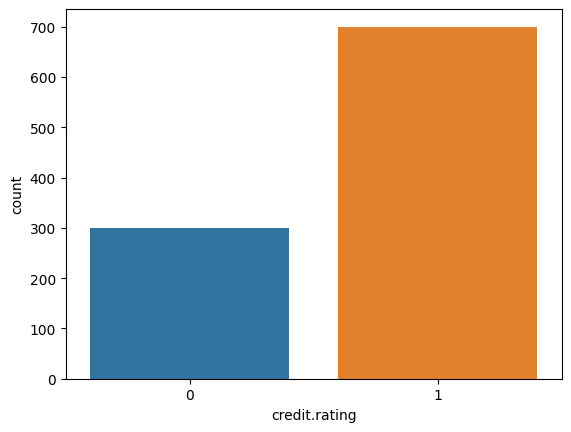

In [4]:
sns.countplot(df, x= 'credit.rating')
plt.show()

## Seleção de Variáveis

Primeiro vamos criar um gráfico para visualizarmos se há forte correlação entre as variáveis, e logo em seguida, avaliaremos se há variáveis com multicolinearidade utilizando autovalores e autovetores.

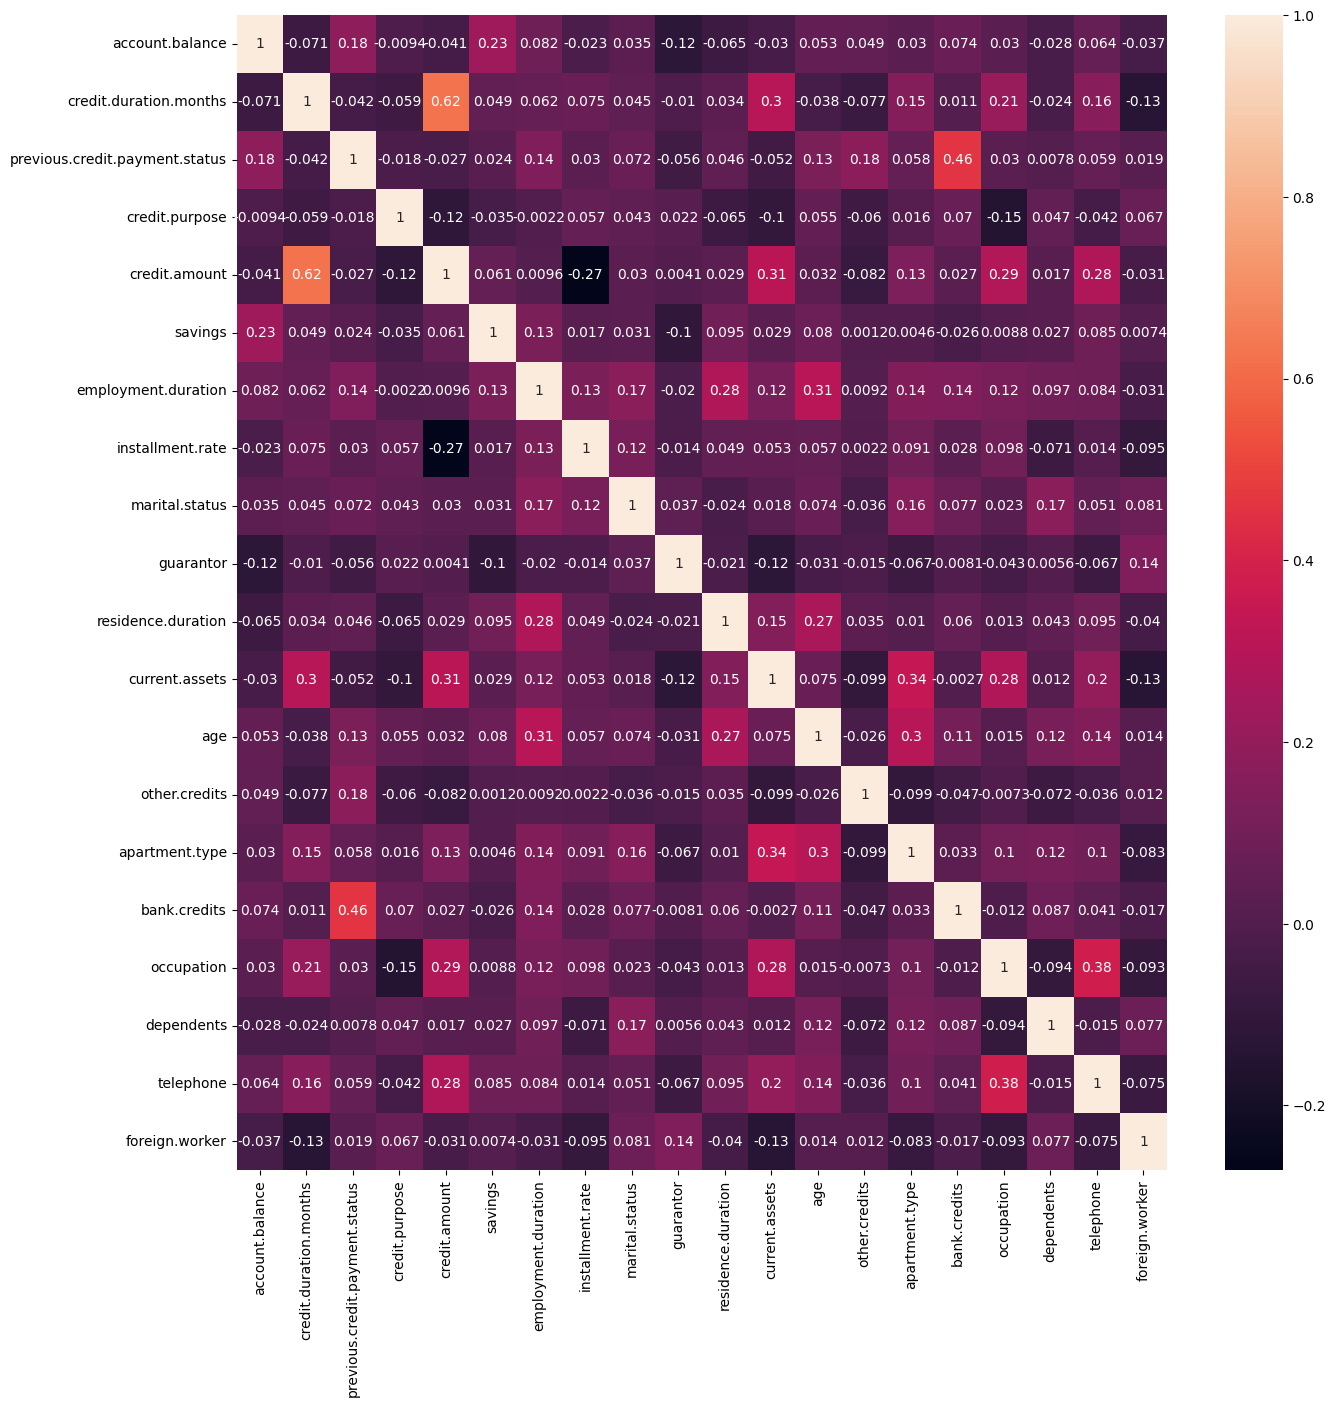

In [5]:
# Criando matriz de correlação
matriz_corr = X.corr()

# Definindo tamanho do gráfico
plt.figure(figsize= (15, 15))

# Plot
sns.heatmap(matriz_corr, annot= True)
plt.show()

In [6]:
# Gerando autovalores e autovetores
corr = np.corrcoef(X, rowvar = 0)
autovalores, autovetores = np.linalg.eig(corr)

In [7]:
print(autovalores)

[2.57703828 1.9515274  1.46184524 0.26064211 1.35240452 1.23482585
 1.20354789 0.4516199  0.49030212 0.52283723 1.10720831 0.63949381
 0.67990328 0.71561954 0.74798575 0.82009364 0.87886133 0.91687459
 0.99729518 0.99007403]


In [8]:
print(autovetores[:,3])

[ 0.00513943 -0.5875848   0.01939139  0.02448346  0.70949682 -0.02096974
  0.06042306  0.33149824 -0.0379273  -0.01479391  0.01202626 -0.04080769
 -0.10204289 -0.0016182   0.02700864 -0.04037525 -0.11635122  0.00269037
 -0.06250788 -0.05177265]


In [9]:
print(variaveis[4], variaveis[7])

credit.amount installment.rate


As variáveis **credit.amount e installment.rate** são responsáveis pela multicoliniaridade no dataset.

## Feature Scaling

Usaremos a técnica de **padronização** para deixar os dados numéricos contínuos na mesma escala.

In [10]:
# Selecionando as variáveis numéricas contínuas
var_num = ['credit.duration.months', 'age', 'credit.amount']

# Aplicando padronização
scaler = StandardScaler()
X[var_num] = scaler.fit_transform(X[var_num])

## Treinamento do Modelo

### Regressão Logística

In [11]:
# Divisão de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3)

In [12]:
# Treinando o modelo
modelo_lr_v1 = LogisticRegression()
modelo_lr_v1.fit(X_train, y_train)

LogisticRegression()

In [13]:
# Previsões
y_pred = modelo_lr_v1.predict(X_test)

In [14]:
# Avaliação do modelo
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Acurácia: {accuracy}')
print(f'Matriz de Confusão:\n{conf_matrix}')
print(f'Relatório de Classificação:\n{classification_rep}')

Acurácia: 0.7933333333333333
Matriz de Confusão:
[[ 40  45]
 [ 17 198]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.70      0.47      0.56        85
           1       0.81      0.92      0.86       215

    accuracy                           0.79       300
   macro avg       0.76      0.70      0.71       300
weighted avg       0.78      0.79      0.78       300



## K-Nearest Neighbor

In [15]:
# Divisão em dados de treino e de teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

In [16]:
# Divisão dos dados de treino em dados de treino e dados de validação
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1)

In [17]:
# Número de registros em cada dataset
print("Registros de Treino: {}".format(len(X_train)))
print("Registros de Validação: {}".format(len(X_val)))
print("Registros de Teste: {}".format(len(X_test)))

Registros de Treino: 720
Registros de Validação: 80
Registros de Teste: 200


In [18]:
# Range de valores de k
kVals = range(1, 30, 2)

# Lista para receber o valor de acurácia
acuracias = []

# Loop em todos os valores de k para testar cada um deles
for k in kVals:
    
    # Treinando o modelo KNN com cada valor de k
    modeloKNN = KNeighborsClassifier(n_neighbors = k)
    modeloKNN.fit(X_train, y_train)
          
    # Avaliando o modelo e atualizando a lista de acurácias
    score = modeloKNN.score(X_val, y_val)
    print("Com valor de k = %d, a acurácia é = %.2f%%" % (k, score * 100))
    acuracias.append(score)

Com valor de k = 1, a acurácia é = 60.00%
Com valor de k = 3, a acurácia é = 66.25%
Com valor de k = 5, a acurácia é = 66.25%
Com valor de k = 7, a acurácia é = 65.00%
Com valor de k = 9, a acurácia é = 67.50%
Com valor de k = 11, a acurácia é = 66.25%
Com valor de k = 13, a acurácia é = 66.25%
Com valor de k = 15, a acurácia é = 68.75%
Com valor de k = 17, a acurácia é = 66.25%
Com valor de k = 19, a acurácia é = 68.75%
Com valor de k = 21, a acurácia é = 71.25%
Com valor de k = 23, a acurácia é = 70.00%
Com valor de k = 25, a acurácia é = 72.50%
Com valor de k = 27, a acurácia é = 71.25%
Com valor de k = 29, a acurácia é = 71.25%


In [19]:
# Obtendo o valor de k que apresentou a maior acurácia
i = np.argmax(acuracias)
print("O valor de k = %d alcançou a mais alta acurácia de %.2f%% nos dados de validação!" % (kVals[i], 
                                                                                             acuracias[i] * 100))

O valor de k = 25 alcançou a mais alta acurácia de 72.50% nos dados de validação!


In [20]:
# Criando a versão final do modelo com o maior valor de k
modelo_knn_v1 = KNeighborsClassifier(n_neighbors = kVals[i])

# Treinamento do modelo
modelo_knn_v1.fit(X_train, y_train)

# Previsões com os dados de teste
y_pred = modelo_knn_v1.predict(X_test)

In [21]:
# Avaliação do modelo
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Acurácia: {accuracy}')
print(f'Matriz de Confusão:\n{conf_matrix}')
print(f'Relatório de Classificação:\n{classification_rep}')

Acurácia: 0.72
Matriz de Confusão:
[[ 16  45]
 [ 11 128]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.59      0.26      0.36        61
           1       0.74      0.92      0.82       139

    accuracy                           0.72       200
   macro avg       0.67      0.59      0.59       200
weighted avg       0.69      0.72      0.68       200

